<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/8_stat_oil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Last amended: 21st May, 2021
Myfolder: 
Ref Kaggle:
   https://www.kaggle.com/c/statoil-iceberg-classifier-challenge

Good examples:
    https://github.com/Microsoft/LightGBM/tree/master/examples/python-guide

Ref: PCA vs TruncatedSVD
   https://stats.stackexchange.com/questions/239481/difference-between-scikit-learn-implementations-of-pca-and-truncatedsvd
   
Evaluation: For each id in the test set, you
            must predict the probability that
            the image contains an iceberg or
            a ship (a number between 0 and 1).

Objectuves:
            1. Learn working of lightgbm
            2. lightgbm
            3. Singular Value Decomposition
            4. Cross-validation in python
            5. Learning curves
            6. Feature importance
            7. Bayesian optimization
            8. Bayesian optimization using skoptimize
               (For Bayesian optimization using hyperopt-sklearn
		see folder 16.hyperopt. This method does not use
	 	Gaussian Processes to search for next hyperparameter
		point.)


"""

## Lightgbm

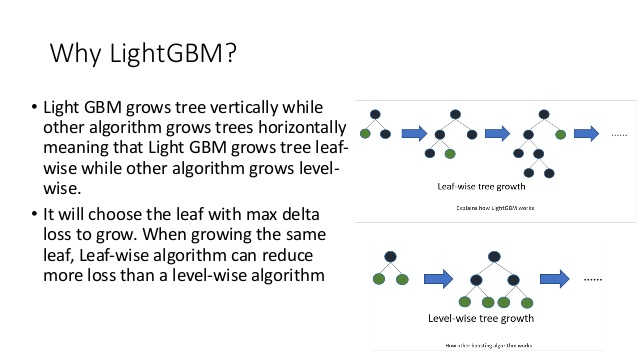

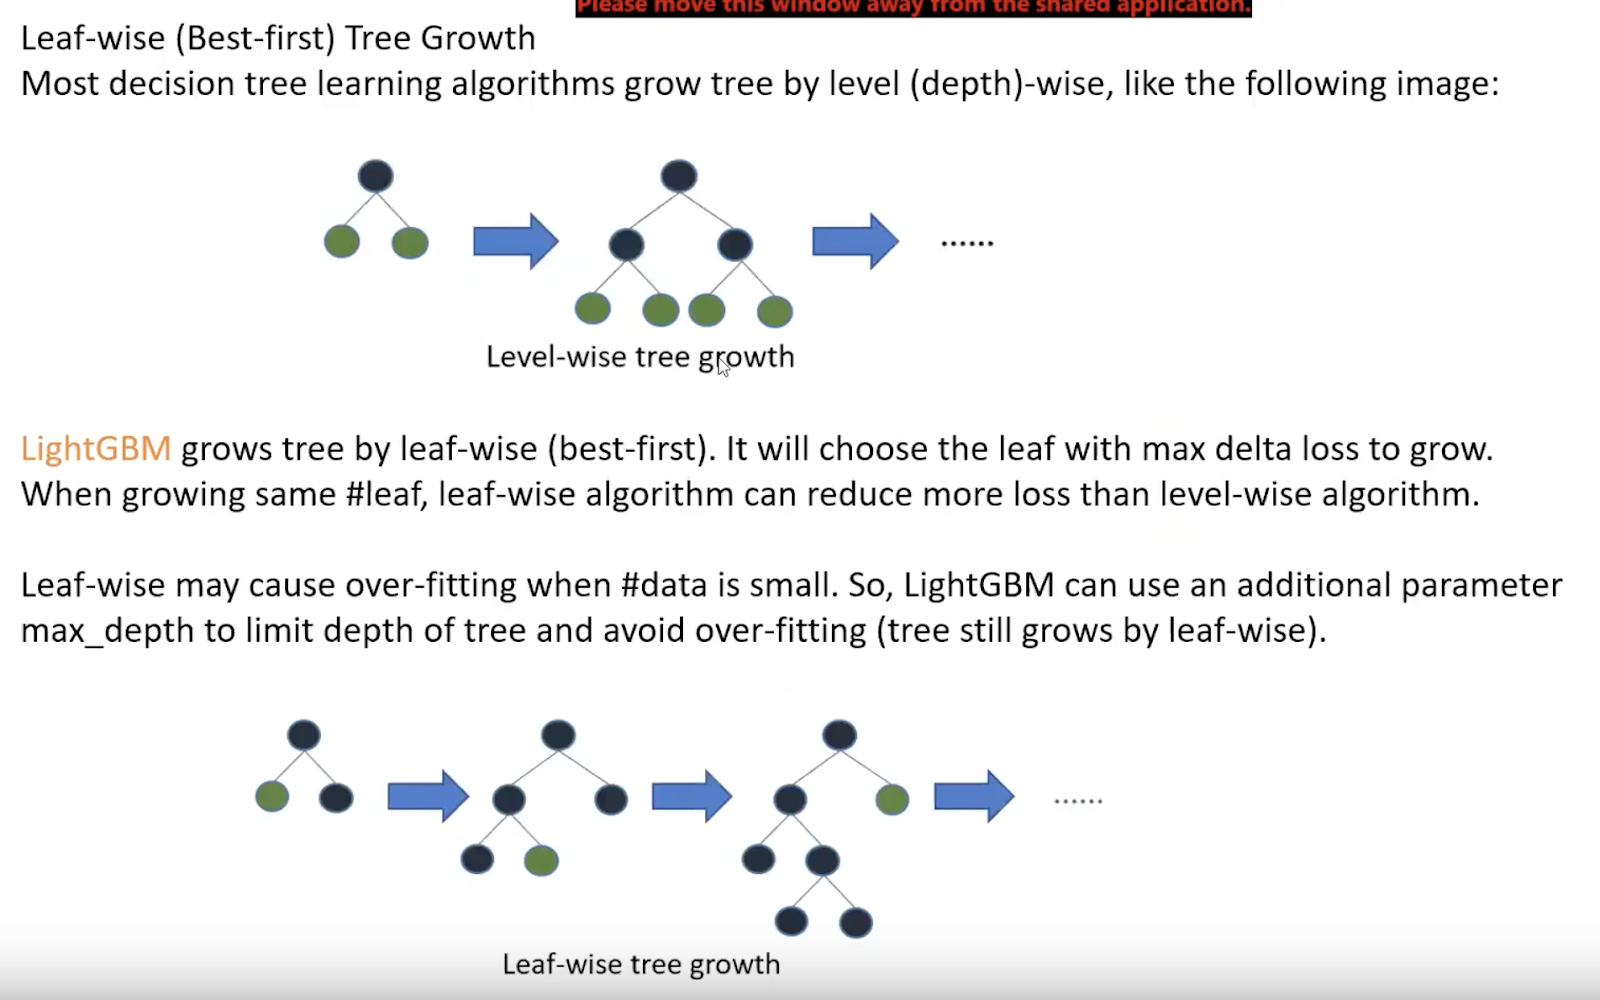

Two good articles on differences between CatBoost vs. Light GBM vs. XGBoost  are:  
1. KDnuggets article [here](https://www.kdnuggets.com/2018/03/catboost-vs-light-gbm-vs-xgboost.html)

2. This [article](https://neptune.ai/blog/lightgbm-parameters-guide) also tells which parameters of lightgbm are important and which are not.

##Install packages

In [77]:
!pip install scikit-optimize
!pip install 'scikit-optimize[plots]'

In [ ]:
! pip install lightgbm --upgrade
lgb.__version__

## Call libraries

In [82]:
## 1.0 Call needed libraries

#%reset -f              # Clear all variables

# 1.1 Load pandas & numpy 
import numpy as np
import pandas as pd

# 1.2 Plotting and image manipulation
from matplotlib.pyplot import imshow, imsave
import matplotlib.pyplot as plt

# 1.3 Image normalizing and compression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1.4 Libraries for splitting, cross-validation & measuring performance
from sklearn.model_selection import train_test_split

# 1.4.1 Return stratified folds. The folds are made by
#        preserving the percentage of samples for each class.

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, roc_curve

# 1.5 ML - we will classify using lightgbm
#          with stratified cross validation
import lightgbm as lgb

# 1.6 OS related
import os, time

# 1.7 Bayes optimization--IInd method
# SKOPT is a parameter-optimisation framewor
#  Install skopt as:
#       conda install -c conda-forge scikit-optimize

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer



In [83]:
# 1.8 Display multiple command outputs from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [84]:
# 1.9 Set option to dislay many rows
pd.set_option('display.max_columns', 100)

In [85]:
#1.10 MOUNT google drive
#    at folder /ashok

from google.colab import drive
drive.mount('/ashok')

Drive already mounted at /ashok; to attempt to forcibly remount, call drive.mount("/ashok", force_remount=True).


## Read Data file

In [86]:
# 2.0 Path to my data
path = "/ashok/MyDrive/Colab_data_files/statoil/"
os.chdir(path)

In [87]:
## 2.0 Train file
trfile = 'train.json.zip'

# 2.1
#testfile = 'test.json'

# 2.2 Read zipped json file
train = pd.read_json(path+trfile)

### Understand data attributes

In [89]:
# 3.0 Examine data
#     exploreData.__doc__  => Gives help

def exploreData(x):
    """Prints various data charteristics, given x
    """
    print ("\nMemory usage (bytes):", np.sum(x.memory_usage()))    # Get size of dataframes
    print("Data shape:", x.shape)
    print("\nColumns:", x.columns)
    print("\nData types\n", x.dtypes)
    print("\nAre there any NULLS\n", np.sum(x.isnull()))
    print("\nDescribe data\n", x.describe())
    print("\nData\n", x.head(2))


In [ ]:
# 3.1 Understand train data
exploreData(train)

In [ ]:
# 3.2 Look at the first point
#     of the first column

# 3.2.1
train['band_1'][0]              # First data point

In [ ]:
# 3.2.2 Examine this Ist point:

len(train['band_1'][0] )        # 5625 = 75 X 75 pixels
print()
print(train['band_1'][0][:4] )  # Look at first four pixel-values

In [ ]:
### Transform the first column
### into an numpy array 

# 3.2.3
b= train['band_1'].values       #    And each data-point in this array
                                #     is a list.

# 3.2.4
type(b)    # numpy.ndarray: An array of lists 

# 3.2.5
print()
type(b[0]) # list

numpy.ndarray

list

In [94]:
# 3.2.6
b.shape    # So how many lists: 1604

# 3.2.7
j = 5                  # Get jth list
print(b[j])            # Look at the jth list or data-point in array
print(b[j][:4])        # Within the jth list (data-point), look at
                       #  Ist four pixel values

(1604,)

[-20.769371, -20.769434, -25.906025, -25.906025, -28.129097, -25.103806, -23.912153, -23.064138, -24.137838, -21.754171, -21.08576, -20.769938, -22.108936, -22.478666, -22.478666, -21.08601, -23.064579, -24.13834, -19.886242, -19.886242, -15.647711, -16.088776, -19.084085, -21.754929, -20.46583, -21.414322, -19.212955, -21.755116, -25.105, -27.435173, -27.435173, -23.065336, -22.47961, -27.107555, -20.771132, -20.771132, -19.476688, -20.028421, -20.172058, -20.927891, -23.065838, -24.609158, -24.139597, -21.931412, -21.249878, -21.75606, -21.75606, -18.119251, -19.477318, -19.08547, -21.75631, -23.270788, -21.415709, -20.172813, -18.351267, -18.469507, -20.467468, -20.772266, -20.618593, -24.610102, -24.610167, -24.372244, -23.695143, -20.029745, -21.088531, -24.61042, -24.140858, -21.416529, -21.932674, -22.481501, -18.120449, -16.84713, -17.567146, -20.468288, -23.481234, -20.769371, -21.247677, -21.413191, -22.864265, -25.103806, -21.929523, -22.108622, -23.064138, -21.582167, -19.8

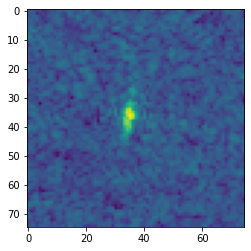

In [95]:
# 3.3 Plot the image contained at the first data-point

img0 = np.array(b[0])          # array
g = img0.reshape(75,75)        # Same as: np.array(b[0]).reshape(75,75)
_=imshow(g)

## Define some useful functions
No data procsessing here

In [96]:
# 4.0 Transform each one of the two pandas series,
#     band_1 and band_2 into a numpy array of 
#     shape 1604 X 5625

def transform_band_to_matrix(df, band_name):
    """df: A dataframe
       band_name: which of the two bands
    """
    # 4.1 Transform the series into an
    #     numpy array of lists:

    b =   df[band_name].values
    
    # 4.2 Create a zero-filled-array of size
    #     1604 X 5625 
    #     Each row of matrix will hold one image
    #     from the band

    x = np.zeros((1604, 5625))  # 1604 X 5625
    
    # 4.3 For every row:
    for j in range(1604):

        # 4.3 Populate jth row of x, x[j,],
        #     with all elements of jth list, b[j].
      
        x[j, :] = np.array(b[j])
        
    return(x)

In [ ]:
"""
Why have a zero filled array:
=============================
    An alternative way of creating
    a matrix 1604 X 5625 is:
        a. Get b[0] & b[1]
        b. Transform both of them to array
            as, np.array(b[0])
        c. Vertically stack them using np.vstack
        d. Then get b[3]. Stack it under
           earleir stack

    But such stacking is not gauranteed to give
    a matrix with adjacent memory locations
"""

In [99]:
# 5.0 Given an array of 1604 X 5625 from above function,
#     plot first six images after reshaping each row
#     array to 75 X 75. That is plot
#     x[0], x[1], ...x[5] after reshaping each
#     to 75 X 75

def plot_first_six_Images(x):
    """x: matrix of size 1604 X 5625
       Given a image matrix with each row
       as an image, plot images in Ist
       six rows.
    """
    # 5.1 Create figure-window and axes
    _, ax = plt.subplots(nrows = 2, ncols= 3)
    # 5.2
    ax[0,0].imshow(x[0, :].reshape(75,75))
    ax[0,1].imshow(x[1, :].reshape(75,75))
    ax[0,2].imshow(x[2, :].reshape(75,75))
    ax[1,0].imshow(x[3, :].reshape(75,75))
    ax[1,1].imshow(x[4, :].reshape(75,75))
    ax[1,2].imshow(x[5, :].reshape(75,75))
    plt.show()



In [100]:
# 6.0 Save one image array to a file in disk 
#     just to look at saved-img size:

def SaveOneImg(x, filename):
    """x is matrix of row-wise images
       Each image in one row
       There are as many images as there are rows
       Saves just one image in the very first row
       Returns saved file size
    """
    # 6.1 Min and Max pixel intensity values
    #     in the first row

    lower = np.min(x[0,:])
    upper = np.max(x[0,:])
    
    # 6.2 Range of values
    range = upper - lower
    
    # 6.3 Normalize array
    trans = (x[0,:] - lower)/range           # Normalize image to values [0,1]
    # 6.4
    imsave(filename, trans.reshape(75,75))   # Reshape image and save it to disk
    return os.path.getsize(filename)         # Return img size on disk

In [101]:
# 7.0 Singular value decomposition of
#     of matrix 1604 X 5625
#     So we have 5625 columns
#     See SVD vs PCA below

def PrincipalComponent(x, n_comp):
    """x is a matrix of images
         or a dataset with 5625 columns
         It is returned from function:
         transform_band_to_matrix().
       n_comp: Number of SVD components
       This function returns three objects:
         a. transformed matrix,
         b. transformation object, and
         c. explained variance
    """
    # 7.1 Create an object to perform PCA
    pca = PCA(n_components = n_comp)

    # 7.2 Fit and transform
    x_trans = pca.fit_transform(x)
    
    # 7.3 % of variance explained by each component
    exp_var_ratio = pca.explained_variance_ratio_
    
    # 7.4 Return a tuple of three values
    return (x_trans, pca, exp_var_ratio)


## Data compression

In [ ]:
################### E. Pre Analyses  ##################
### Our steps in Modeling
##  Brief steps: ################
#   1. Reshape single column, band_1, into an array 5625 columns
#   2. Reshape single column, band_2, into 5625 columns
#   3. Truncate 5625 cols of band_1 to 25 cols using PCA
#   4. Truncate 5625 cols of band_2 to 25 cols using PCA
#   5. Concatenate two expanded column. Result: 50 cols
#   6. Cut inc_angle into two, to create a categorical
#      variable having two categories
#   7. To (5) above, concatenate two more columns:
#      One: of 'inc_angle' and Two: categorical column
#      created in step (6)
#   8. Do modeling
#   9. While modeling tune parameters of model using Bayes
#      optimization technique
################


(1604, 5625)

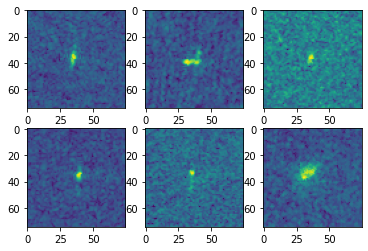

In [102]:
## 8. Popualte a variable with flattened images
#      from band_1.
#      Band 1 and Band 2 are signals characterized
#      by radar backscatter produced from different
#      polarizations at a particular incidence angle.

matrix_band1 = transform_band_to_matrix(train, "band_1")
matrix_band1.shape           # 1604 X 5625

# 8.1 Also plot six of the satellite images
plot_first_six_Images(matrix_band1)



In [103]:
## 9.0 Popualte another variable with flattened images from band_2

matrix_band2 = transform_band_to_matrix(train, "band_2")
matrix_band2.shape

(1604, 5625)

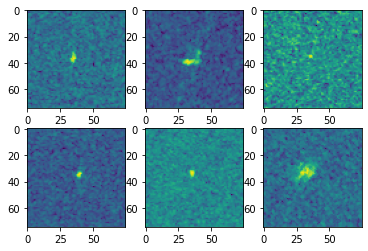

In [104]:
# 9.1 Also plot six images from it

plot_first_six_Images(matrix_band2)

In [105]:
## 9.2  Save one image from band1 into a file
#       Returned value is file size

filesize = SaveOneImg(matrix_band1, "band1.jpg")
filesize                # 1695 bytes

1689

In [106]:
# 9.3 Perform Singular Value Decomposition
#     Get how much variance is explained per-component
#     in band1. Start with total of 500 components

_,_,ev1 = PrincipalComponent(matrix_band1, 500)
_,_,ev2 = PrincipalComponent(matrix_band2, 500)

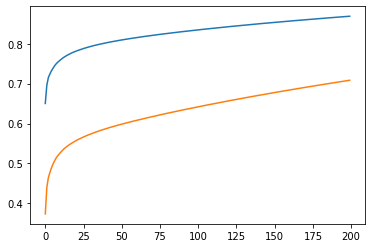

In [ ]:
# 9.4. Plot the cumulative sum of explained variances
#     component-wise for both the bands

_=plt.figure()
frac_band1 = np.cumsum(ev1)     #[1,2,3,4] => [1,3,6,10]
frac_band2 = np.cumsum(ev2)
_=plt.plot(frac_band1[:200])    # 25 components appear OK
_=plt.plot(frac_band2[:200])    # 25 components appear OK
plt.show()

In [123]:
# 10 . Next, let us , therefore, truncate to 25 components
#      Singular value decomposition of two bands of train data
#      So new flattened images are in comp1 and in comp2

pca_comp1,pca_obj1, _ = PrincipalComponent(matrix_band1, 25)
pca_comp2,pca_obj2, _ = PrincipalComponent(matrix_band2, 25)

In [124]:
# 11. We can perform inverse_transform with just 25 svd components
#     and relook at images (75 X 75) to visually see how much of
#     information relating to original image does exist
im1_compr = pca_obj1.inverse_transform(pca_comp1)
im2_compr = pca_obj2.inverse_transform(pca_comp2)

# 11.1
im1_compr.shape      # Shape remains as 1604 X 5625, as earlier
im2_compr.shape

(1604, 5625)

(1604, 5625)

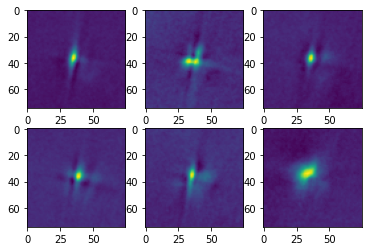

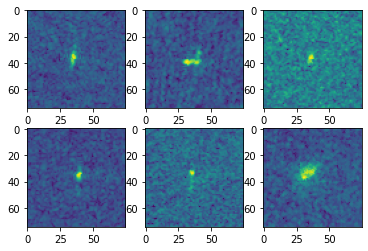

In [110]:
# 12. Now, relook at transformed and original images
#     Transformed first
plot_first_six_Images(im1_compr)

# 12.1 Compare above with original. Not bad..
plot_first_six_Images(matrix_band1)

In [111]:
## 13. Does SVD compress image?
##     Save transformed image
#      And compare its size with that of original image
#      saved earlier
##     Obviously SVD compresses image

SaveOneImg(im1_compr, "im1.jpg")      # Size: 713 bytes as against 1695 bytes

1105

In [112]:
### 14. Finally we horizontally stack flattened images
#       Note here that comp1 and comp2 may be at
#       difft memory locations.
#       Better option would be to create a zero-filled
#       of size 1604 X 50: 

X = np.hstack((comp1, comp2))
X.shape  # (1604, 50)

(1604, 50)

In [113]:
# 14.1 Another way of stacking

X = np.zeros((1604, 50))
X[:,:25]  = comp1
X[:, 25:] = comp2 

In [114]:
# 14.2 Target
y = train['is_iceberg'].values         # Target

##Modeling

In [115]:
# 15.1 Partition data into train/test:

X_train, X_test, y_train, y_test = train_test_split(
                                                      X, y,
                                                      test_size=0.30
                                                     )

### Bayesian optimization

In [ ]:
# Refer:
# https://www.kaggle.com/nanomathias/bayesian-optimization-of-xgboost-lb-0-9769
# Refer for LGBMRegressor:
#   https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.LGBMRegressor
# And  https://lightgbm.readthedocs.io/en/latest/Parameters.html

# Our modeling object for Classification
# Can be any modeler: RandomForest, xgboost, neuralnetwork
#                     svm etc

#### Model object

In [151]:
# 16. Define classifier object:

model = lgb.LGBMRegressor(                # Regressor will also perform classification
                            objective='binary',
                            metric='auc', # This output must match with what
                                          #  we specify as input to Bayesian model
                            n_jobs=2,
                            verbose=0,
                            #baggeng_freq=1,
                            #bagging_fraction =0.8,
                          )

#### Parameter-space

In [152]:
# 16.1 Parameter search space for selected modeler
#      For suggested parameter grid for lightgbm, pl see: 
#         https://github.com/Microsoft/LightGBM/issues/695
#
params = {
        # The 'boosting' option parameter give lots of errors. 
        # Do not use it. (Removed 'rf' from it.)
        'boosting'    :   Categorical(['gbdt','dart']),                                                         
        'n_estimators':   Integer(50, 100), # No of boosted trees or iterations to fit (default: 100).

        'num_leaves'  :   Integer(5,45),   # Max tree leaves for base boosters
                                           # Create a node only if no of leaves exceed this limit
                                           #  and also following condition of 'min_child_samples' is met

        'min_child_samples': Integer(1, 50),  # Create a node only if min data-points at this node
                                              #  exceed this limit

        'feature_fraction' : Real(0.1, 0.9),  # Randomly select part of features on each iteration
                                              #  for every boosted tree

        'bagging_fraction' : Real(0.8, 1),   # Randomly select part of data without resampling
                                             #   for each boosted tree

        'bagging_freq'     : Integer(1,10),  # k means perform bagging at every k iteration

        'max_depth'        : Integer(1, 50), # Max tree depth for base learners, -1 means no limit.

        'learning_rate': Real(0.01, 1.0, 'log-uniform'), # Prob of interval 1 to 10 is same as 10 to 100
                                                         # Equal prob of selection from 0.01 to 0.1, 0.1
                                                         # to 1
                                                         # In a loguniform distributon, log-transformed
                                                         # random variable is uniformly distributed

        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),  # L2 regularization term on weights.
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),    #  L1 regularization


        'scale_pos_weight': Real(1, 10),       # default: 1
                                               # used only in binary application
                                               # How much more importance should be given to binary
                                               # weight of labels with positive class


        #-----***** Not understood **** -----

        'max_bin': Integer(100, 1000),        # max number of bins that feature
                                              #  values will be bucketed in
                                              # small number of bins may reduce
                                              # training accuracy but may increase
                                              # general power (deal with over-fitting)

        'min_child_weight': Real(1, 10),      # Deals with overfitting

        'subsample_for_bin': Integer(100000, 500000)  #  Number of samples for constructing bins(default: 200000)
                                               # setting this to larger value will give better training
                                               #  result, but will increase data loading time


        }



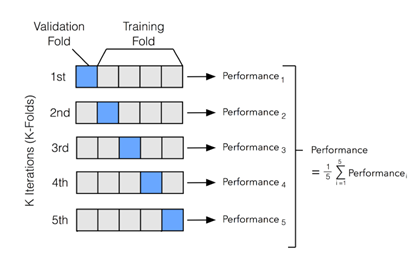

#### Cross-validation strategy

In [153]:
# 16.2 Cross validation strategy for the modeler
#      Perform startified k-fold cross-validation
#      There is also RepeatedStratifiedKFold() class
#      that will repeat startified k-fold N-number
#      of times
#      Instantiate cross-vlidation object
"""
Examples of Cross-validation strategies:
    i)   Leave one out  : Very time consuming
    ii)  Leave P out    : For example, leave 2 out
    iii) kfold          : k-equal random folds
    iv)  StratifiedKFold : kfolds + stratification
    v)   ShuffleSplit  => Generate n-numbers of userdefined pairs
                          of (train,test). For examples, in each
                          (train,test) pair, let number of rows
                          of 'test' data be 30% of train data

"""

cvStrategy = StratifiedKFold(
                             n_splits=3,
                             shuffle=True,
                             random_state=42
                            )



"\nExamples of Cross-validation strategies:\n    i)   Leave one out  : Very time consuming\n    ii)  Leave P out    : For example, leave 2 out\n    iii) kfold          : k-equal random folds\n    iv)  StratifiedKFold : kfolds + stratification\n    v)   ShuffleSplit  => Generate n-numbers of userdefined pairs\n                          of (train,test). For examples, in each\n                          (train,test) pair, let number of rows\n                          of 'test' data be 30% of train data\n\n"

#### Bayes tuner object

In [154]:
# 16.3 Bayesian object instantiation
#     For API, refer: https://scikit-optimize.github.io/#skopt.BayesSearchCV
#     For example: https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html

bayes_cv_tuner = BayesSearchCV(
                              estimator = model,    # rf, lgb, xgb, nn , pipeline etc--Black box
                              search_spaces = params,  # Specify params as required by the estimator
                              scoring = 'roc_auc',  # Input to Bayes function
                                                    # modeler should return this
                                                    # peformence metric
                              cv = cvStrategy,      # Optional. Determines the cross-validation splitting strategy.
                                                    #           Can be cross-validation generator or an iterable,
                                                    #           Possible inputs for cv are: - None, to use the default 3-fold cv,
                                                    #           - integer, to specify the number of folds in a (Stratified)KFold,
                                                    #           - An object to be used as a cross-validation generator.
                              n_jobs = 2,           # Start two parallel threads for processing
                              n_iter = 50,        # How many times to look for parameter sets
                              verbose = 1,
                              refit = True,       #  Refit the best estimator with the entire dataset
                              random_state = 42
                               )


#### Begin tuning

In [ ]:
# 16.4 Start learning using Bayes tuner

start = time.time()
result = bayes_cv_tuner.fit(
                           X_train,       # Note that we use normal train data
                           y_train       #  rather than lgb train-data matrix
                           #callback=status_print
                           )

end = time.time()
(end - start)/60


#### Results

In [128]:
# 17.0 So what are the results?
#      Use the following estimator in future
#      What parameters the best estimator was using?

best_params = pd.Series(bayes_cv_tuner.best_params_)
print(best_params)

# 17.1 Best auc score for the above estimator

print("\n\nBest score: ", np.round(bayes_cv_tuner.best_score_, 4))


bagging_fraction        0.923416
bagging_freq                   8
boosting                    dart
feature_fraction         0.79946
learning_rate           0.153193
max_bin                      635
max_depth                     33
min_child_samples             22
min_child_weight         7.60494
n_estimators                  82
num_leaves                    42
reg_alpha            0.000833057
reg_lambda             0.0219248
scale_pos_weight         4.11378
subsample_for_bin         287406
dtype: object


Best score:  0.9015


In [129]:
# 17.2 Summary of all models developed by Bayes process

allModels_summary = pd.DataFrame(bayes_cv_tuner.cv_results_)
allModels_summary.shape  # 50 X 26 ; 50 iterations

# 17.3
allModels_summary.head()

(50, 26)

,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bagging_fraction,param_bagging_freq,param_boosting,param_feature_fraction,param_learning_rate,param_max_bin,param_max_depth,param_min_child_samples,param_min_child_weight,param_n_estimators,param_num_leaves,param_reg_alpha,param_reg_lambda,param_scale_pos_weight,param_subsample_for_bin,params
0,0.900066,0.905280,0.877566,0.894304,0.012025,11,2.472278,1.617071,0.023862,0.021007,0.882021,8,gbdt,0.352640,0.218925,473,18,37,3.740170,82,27,1.385174e-08,1.370904e-07,6.688861,131156,"{'bagging_fraction': 0.8820207917706628, 'bagg..."
1,0.895227,0.899116,0.890196,0.894846,0.003651,9,0.368434,0.143202,0.021388,0.015205,0.967478,9,dart,0.860979,0.534879,156,8,18,6.721562,98,30,8.524050e-01,1.590337e+00,4.496724,342928,"{'bagging_fraction': 0.9674776711106569, 'bagg..."
2,0.873275,0.866822,0.844262,0.861453,0.012438,30,0.703811,0.242206,0.011063,0.006248,0.888967,9,dart,0.446666,0.023763,508,9,38,6.016064,99,33,2.711809e-06,2.367361e-07,5.585960,278139,"{'bagging_fraction': 0.8889665024602303, 'bagg..."
3,0.902400,0.899692,0.870040,0.890711,0.014658,13,6.965580,4.846320,0.005723,0.002214,0.962479,3,gbdt,0.742212,0.111200,186,38,44,9.207360,69,19,3.449623e-02,2.114410e-02,1.236578,485880,"{'bagging_fraction': 0.9624791976714727, 'bagg..."
4,0.886123,0.885288,0.866551,0.879321,0.009036,21,0.342524,0.132231,0.002959,0.000096,0.959911,5,gbdt,0.672571,0.642250,745,22,33,4.177755,83,26,8.740059e-02,1.165902e-06,3.383559,207155,"{'bagging_fraction': 0.9599106883214347, 'bagg..."


In [131]:
### 17.4. Let us now use the best estimator
bst_bayes = bayes_cv_tuner.best_estimator_

# 17.5 Make predictions
pred = bst_bayes.predict(X_test)
print(pred[:4])

# 17.6 So what is auc score
fpr, tpr, thresholds = roc_curve(
                                  y_test,
                                  pred,
                                  pos_label=1
                                 )

print("\n\nAUC: ", auc(fpr, tpr) )   # 94%


[0.84641    0.87805058 0.14336566 0.96771303]


AUC:  0.923675556550335


#### ROC curve

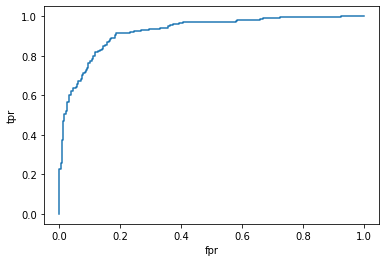

In [150]:
# 28. Plot ROC curve
from sklearn.metrics import roc_curve

y_pred = bst_bayes.predict(X_test)
x,y, _ = roc_curve(y_test, y_pred)   # Retuns a tuple of three arrays
                                     # fpr,tpr,thresholds
 
_=plt.plot(x,y)
_=plt.xlabel("fpr")
_=plt.ylabel("tpr")
plt.show()


#### Precision-Recall curve

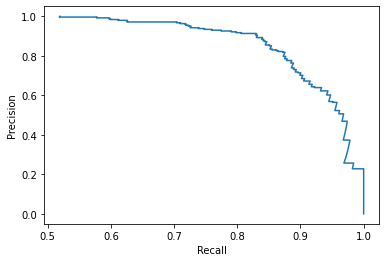

In [138]:
# 28. Plot precision/Recall curve
#  Ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
from sklearn.metrics import precision_recall_curve as pr
y_pred = bst_bayes.predict(X_test)
precision,recall,_ = pr(y_test,y_pred)   # Reruns a tuple of three arrays
                                         # precision, recall, thresholds
_=plt.plot(precision,recall)
_=plt.xlabel("Recall")
_=plt.ylabel("Precision")
plt.show()

#### Feature Importances

In [132]:
# 18.0
bst_bayes.feature_importances_

array([85, 60, 25, 59, 53, 37, 68, 52, 66, 54, 58, 21, 45, 33, 26, 41, 29,
       16, 44, 26, 19, 24, 23, 18, 20, 30, 48, 38, 22, 40, 70, 38, 40, 34,
       29, 48, 43, 69, 21, 19, 24, 36, 28, 27, 25, 21, 21, 40, 25, 22],
      dtype=int32)

Plot feature importances...


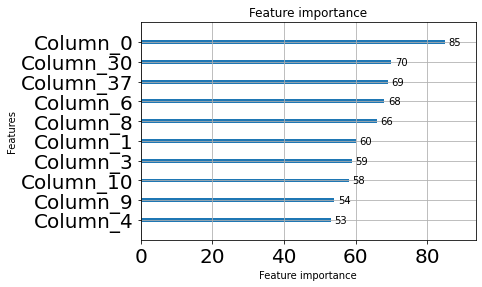

In [133]:
# 18.1 Plot feature importances:
# Column wise imporatnce. Default Criteria: "split".
# "split":  Result contains numbers of times feature is used in a model.
# “gain”:   Result contains total information-gains of splits
#           which use the feature

print('Plot feature importances...')
ax = lgb.plot_importance(bst_bayes, max_num_features=10)
ax.tick_params(labelsize=20)
plt.show()

## LightGBM trees

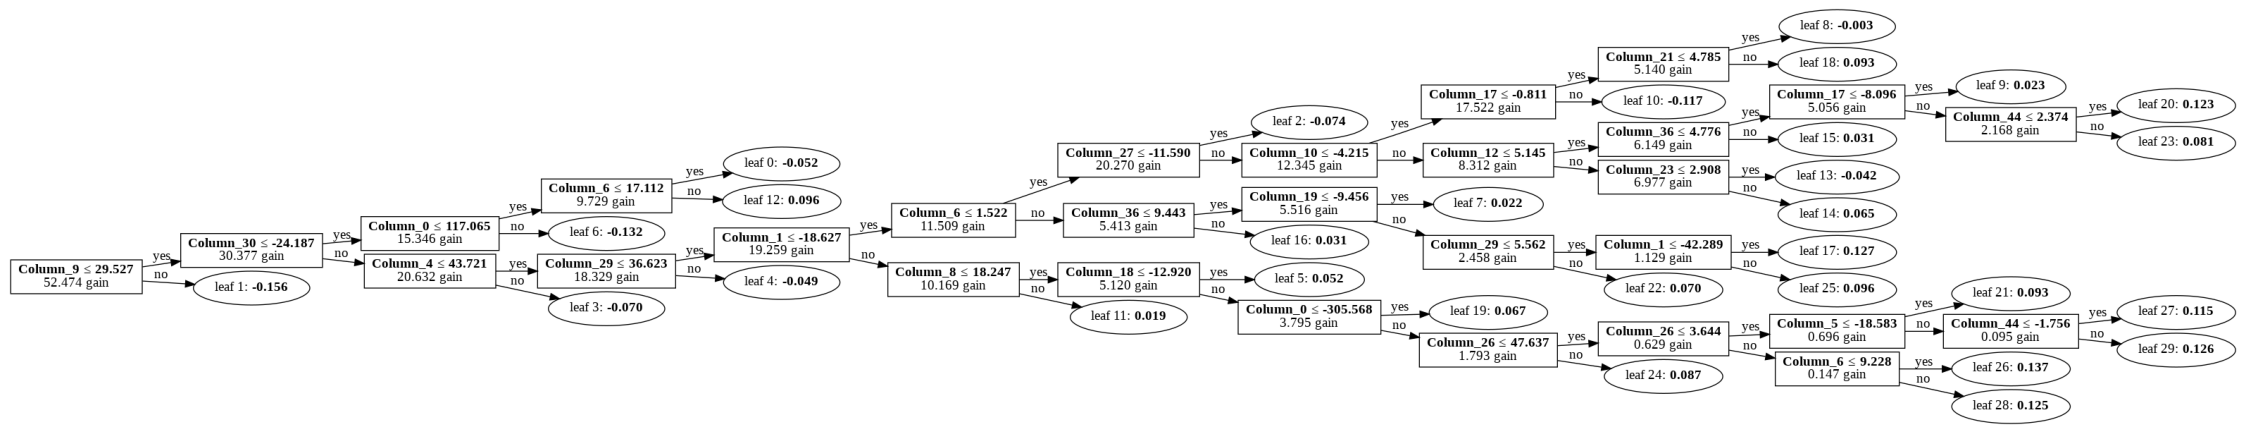

In [134]:
# 19.0 Draw 10th tree:

ax= lgb.plot_tree(
                  bst_bayes,
                  tree_index=9,
                  figsize=(40, 20),
                  show_info=['split_gain']
                  )

plt.show()


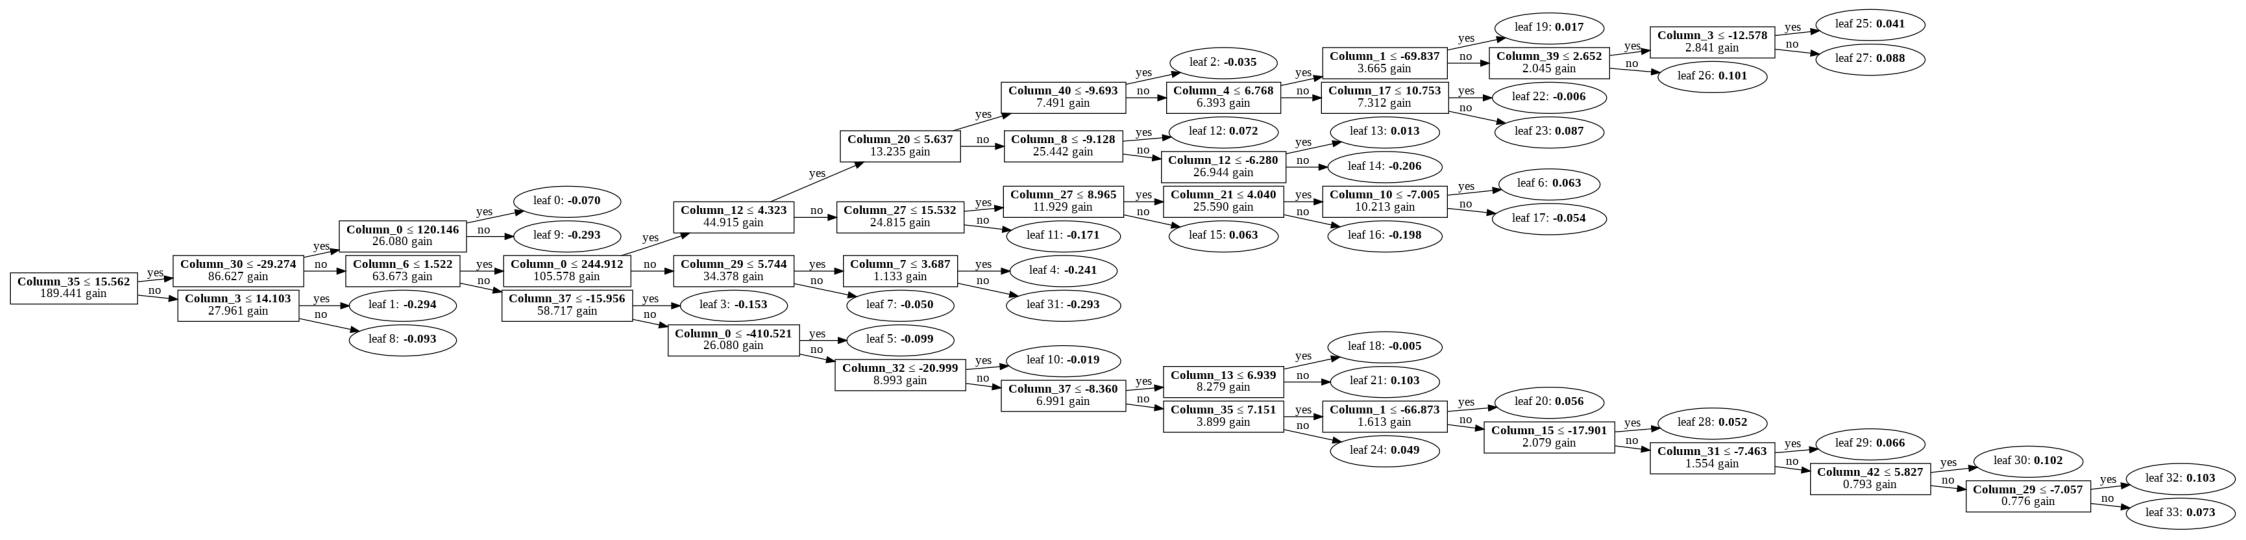

In [135]:
# 19.1 Draw 1st tree:

ax= lgb.plot_tree(
                  bst_bayes,
                  tree_index=0,
                  figsize=(40, 20),
                  show_info=['split_gain']
                  )

plt.show()


## Learning Curve & Extra
Code not checked

In [ ]:
############## Learning Curve with lightgbm #############
## What is a Learning Curve--See note at the end.

# Ref: https://lightgbm.readthedocs.io/en/latest/Python-API.html#training-api
# 24. Store train and test data in lightgbm,
#     Dataset object


d_train = lgb.Dataset(X_train, label=y_train) # transformed train data
d_test = lgb.Dataset(X_test, label = y_test)  # test data

# 24.1 Watch error in these datasets as
#      modeling proceeds
watchlist = [d_train, d_test]

## 25. Build Lightgbm model
# Set parameters first
# Ref: http://lightgbm.readthedocs.io/en/latest/Python-Intro.html
#      https://lightgbm.readthedocs.io/en/latest/Parameters.html

params = { 'learning_rate': 0.25,
           'verbosity': -1,             # Be verbose when processing
           'categorical_feature' : [51],  # which cols are categorical
                                          # (specify index 0,1,2..)
            'nthread': 4,                 # USe CPU cores
            'max_depth': 7,            # limit the max depth for tree model
            'objective' : "binary",
            'metric' : ['auc', 'binary_logloss']
           }


## 26
start = time.time()
# 26.1
evals_result = {} # to record eval results for plotting
model = lgb.train(params,
                  train_set=d_train,
                  num_boost_round=1500,     # 1000 residuals are mapped to functions
                                            #   successively
                  valid_sets=watchlist,
                  early_stopping_rounds=100, # The goal of early stopping is to
                                            #  decide if any of the latest X rounds
                                            #  has improved performance versus a baseline,
                                            #  according to some metric.
                                            # The model will train until the validation
                                            #  score stops improving. Validation error
                                            #  needs to improve at least every
                                            #  early_stopping_rounds to continue training.
                 evals_result=evals_result, # Record evaluation results for plotting
                 verbose_eval=10
                 )

# 26.2
end = time.time()
end - start

# 27. Plot learning curve
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='binary_logloss')
plt.show()


# 28. Plot precision/Recall curve
#  Ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
from sklearn.metrics import precision_recall_curve as pr
y_pred = model.predict(X_test)
precision,recall,_ = pr(y_test,y_pred)   # Reruns a tuple of three arrays
                                         # precision, recall, thresholds
plt.plot(precision,recall)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


#################### Bayesian-optimization-II Normal method ###################
# Ref: https://github.com/fmfn/BayesianOptimization

# 25. Create lightgbm dataset, a binary file
#     LightGBM binary file
#     Also saving Dataset into a LightGBM binary file will make loading faster:
d_train = lgb.Dataset(X_train, label=y_train) # transformed train data
d_test = lgb.Dataset(X_test, label = y_test)  # test data


# 25.1
#  Step 1: Create a function that when passed some parameters
#          evaluates results using cross-validation
def lgb_eval(num_leaves,feature_fraction, bagging_fraction,max_depth):
    # Specify complete list of parameters: static and dynamic
    # 25.2 Static: Parameters that need not be modified
    params = {'application':'binary',
              'num_boost_round':4000,
              'learning_rate':0.05,
              'early_stopping_round':100,
              'metric':'auc',
              'shuffle':True
              }

    # 25.3 Dynamic: Parameters that would be passed using arguments to function
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = feature_fraction
    params['bagging_fraction'] = bagging_fraction
    params['max_depth'] = int(round(max_depth))

    # 25.4 Now evaluate with above parameters
    cv_result = lgb.cv(params,
                       d_train,
                       nfold=4,
                       seed=0,
                       stratified=True,
                       #verbose_eval =200,
                       metrics=['auc'])

    # 25.5 Finally return maximum value of result
    return max(cv_result['auc-mean'])


# 26. Step 2: Define BayesianOptimization function has
#             two arguments
lgbBO = BayesianOptimization(
                             lgb_eval,               # Which function will evaluate

                             # Parameters to tune and to be
                             #   passed to above function
                             # Specify parameter range for each
                             {'num_leaves': (24, 45),
                              'feature_fraction': (0.1, 0.9),
                              'bagging_fraction': (0.8, 1),
                              'max_depth': (5, 8.99)
                              }
                             )

# 26.1. Gaussian process parameters
gp_params = {"alpha": 1e-5}      # Initialization parameter for gaussian
                                 # process

# 27. Step 3: Start optimization
start = time.time()
lgbBO.maximize(init_points=2,    # Number of randomly chosen points to
                                 # sample the target function before
                                 #  fitting the gaussian Process (gp)
                                 #  or gaussian graph
               n_iter=25         # Total number of times the
                                 #   process is to repeated
               )
end = time.time()
f"Minutes: {(end -start)/60}"



# 28. Get results
lgbBO.max
lgbBO.max['params']['max_depth']
lgbBO.max['params']['bagging_fraction']
lgbBO.max['params']['feature_fraction']
lgbBO.max['params']['num_leaves']

# 29. Newly discovered parameter values
params_new = lgbBO.max['params']
params_new['num_leaves'] = int(params_new['num_leaves']) + 1
params_new['max_depth'] = int(params_new['max_depth']) + 1


# 29.1 Objective alias 'application'
params_new['objective'] = ['binary']    # Default regression

# 29.2 Metric parameters
params_new['metric'] = ['auc', 'binary_logloss']   # Multiple loss parameters


# 29.3 Watch error in these datasets as
#      modeling proceeds
watchlist = [d_train, d_test]


# 30
start = time.time()
model = lgb.train(params_new,
                  train_set=d_train,
                  num_boost_round=1000,     # 1000 residuals are mapped to functions
                                            #   successively
                  valid_sets=watchlist,
                  early_stopping_rounds=20, # The goal of early stopping is to
                                            #  decide if any of the latest X rounds
                                            #  has improved performance versus a baseline,
                                            #  according to some metric.
                                            # The model will train until the validation
                                            #  score stops improving. Validation error
                                            #  needs to improve at least every
                                            #  early_stopping_rounds to continue training.
                  evals_result=evals_result, # Record evaluation results for plotting
                  verbose_eval=10)


end = time.time()
end - start

# 30.1
model.best_score

# 30.2 Save model to a text file for later use
model.save_model('model.txt',
                 num_iteration=model.best_iteration
                 )

# 30.3 Delete model
del model

# 30.4 Load back saved model
bst = lgb.Booster(model_file='model.txt')  #init model

# 30.5 If early stopping is enabled during training,
#      get predictions from the best iteration with
#      bst.best_iteration

lgb_pred = bst.predict(X_test,
                       num_iteration=bst.best_iteration)  > 0.5
lgb_pred
y_test

# 30.6 Now accuracy
np.sum(lgb_pred == y_test)/y_test.size
# 30.7 So what is auc score
fpr, tpr, thresholds = roc_curve(y_test, lgb_pred, pos_label=1)
auc(fpr, tpr)



#####################################################
################ SVD vs PCA ###################
"""
Ref:
   https://stats.stackexchange.com/a/87536/78454

SVD is slower than PCA but is often considered to be the preferred
method because of its higher numerical accuracy.
As you state in the question, principal component analysis (PCA) can
be carried out either by SVD of the centered data matrix X.

Matlab's help records this:
Principal component algorithm that pca uses to perform the
principal component analysis [...]:
[PCA uses two methods, svd and eigenvalue BUT unlike in SVD
PCA is done (on column-wise) centered data]



 i)    'svd' -- Default. Singular value decomposition (SVD) of X.
                         Slower but more accurate
 ii)   'eig' -- Eigenvalue decomposition (EIG) of the covariance matrix.
                The EIG algorithm is faster than SVD when the number of
                observations, n, exceeds the number of variables, p, but
                is less accurate because the condition number of the
                covariance is the square of the condition number of X.
                Faster but less accurate


"""

"""
Learning Curve--General definition
Ref: https://stackoverflow.com/a/13715276

    One line:  How a model performs as some hyperparameter is varied

    A learning curve conventionally depicts improvement in performance
    on the vertical axis when there are changes in another parameter
    (on the horizontal axis), such as training set size (in machine learning)
    or iteration/time (in both machine and biological learning). One salient
    point is that many parameters of the model are changing at different points
    on the plot.

    """
###############################
